<font size="6"><b>Portfolio Optimization Model</b></font>

Objective Function: Optimize return on investment for a given level of risk or minimize risk for a given level of return
(will be maximizing Sharpe Ratio)

<p>In this portfolio I will only be investing in Apple, Microsoft, Google, and Amazon. I am pulling the data using Yahoo Finance API</p> 


In [19]:
pip install yfinance numpy pandas scipy matplotlib seaborn PyPortfolioOpt

Note: you may need to restart the kernel to use updated packages.


In [20]:
import yfinance as yf
import pandas as pd

# Define the tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']

# Download historical data
data = yf.download(tickers, start='2015-01-01', end='2024-01-01')['Adj Close']

# Display the first few rows
data.head()




[*********************100%%**********************]  4 of 4 completed


Ticker,AAPL,AMZN,GOOGL,MSFT
Date,,,,
2015-01-02,24.402172,15.4260,26.447147,40.305367
2015-01-05,23.714720,15.1095,25.943224,39.934727
2015-01-06,23.716959,14.7645,25.302961,39.348595
2015-01-07,24.049519,14.9210,25.228544,39.848522
2015-01-08,24.973555,15.0230,25.316446,41.020805


<font size="4"><b> Calculating Returns and Covariance Matrix </b></font>

* .pct_change(): pandas function that computes the percentage change between the current and prior element.
* .dropna(): removes any rows that contain NaN values.

In [21]:
# Calculate daily returns
returns = data.pct_change().dropna()

# Display the first few rows of returns
returns.head()


Ticker,AAPL,AMZN,GOOGL,MSFT
Date,,,,
2015-01-05,-0.028172,-0.020517,-0.019054,-0.009196
2015-01-06,0.000094,-0.022833,-0.024679,-0.014677
2015-01-07,0.014022,0.010600,-0.002941,0.012705
2015-01-08,0.038422,0.006836,0.003484,0.029418
2015-01-09,0.001072,-0.011749,-0.012211,-0.008405


<font size="4"><b>Covariance Matrix</b></font>
<p>A square matrix that shows the covariance between each pair of variables in a dataset. For my model, these elements represent the returns of different assets.</p>

* The diagonal elements are the variances of the returns of each asset.
* The off-diagonal elements are the covariances between the returns of different assets.
* Positive covariance means they tend to move in the same direction, while negative covariance means they move in opposite directions.

In [22]:
# Calculate mean returns
mean_returns = returns.mean()

# Calculate the covariance matrix
cov_matrix = returns.cov()

print("Mean Returns:\n", mean_returns)
print("\nCovariance Matrix:\n", cov_matrix)



Mean Returns:
 Ticker
AAPL     0.001079
AMZN     0.001230
GOOGL    0.000896
MSFT     0.001139
dtype: float64

Covariance Matrix:
 Ticker      AAPL      AMZN     GOOGL      MSFT
Ticker                                        
AAPL    0.000335  0.000218  0.000205  0.000223
AMZN    0.000218  0.000439  0.000246  0.000241
GOOGL   0.000205  0.000246  0.000323  0.000229
MSFT    0.000223  0.000241  0.000229  0.000307


<font size="5"><b>The Sharpe Ratio</b></font> 
<p>(Expected Portfolio Return - Risk Free Rate) / Portfolio standard deviation (a measure of risk)</p>

<p>Measures the excess return per unit of risk of an investment asset or a portfolio.</p>

<b>Interpretation</b>
* Positive Sharpe Ratio: Indicates that the investment returns exceed the risk-free rate, after adjusting for risk. Higher values are better.
* Negative Sharpe Ratio: Indicates that the investment returns are less than the risk-free rate, suggesting poor performance.

<b>Risk Free Rate</b>
* For long-term investments, the yield on longer-term government bonds.
* According to Ycharts.com, I chose 4% as the current yield on long-term government bonds.

<b>Negative Sharpe Ratio Function</b>
* Portfolio Return: calculates the expected return of the portfolio as the dot product of asset weights and their mean returns.
* Portfolio Volatility: calculates the portfolio's standard deviation (volatility). This is done by first computing the weighted covariance matrix and then taking the square root.
* Sharpe Ratio: sharpe_ratio = computes the Sharpe ratio, which is the excess return over the risk-free rate per unit of risk.

<b>Constraints and Bounds</b>
* Define constraints to ensure that the portfolio is fully invested, meaning that the sum of the weights of all assets must equal 1.
    * To prevent over-leveraging (allocating more than 100% of the capital) or under-investing (allocating less than 100%).
* fun: lambda x: np.sum(x) - 1 is a function that should return 0 when the constraint is satisfied.
* Each weight in the portfolio should be non-negative and should not exceed 1. This is because:
    1. Non-Negativity: Prevents short selling (assigning negative weights).
    2. Upper Bound: Ensures no single asset takes more than 100% of the capital.

<b>Initial Guess</b>
* Required to start the optimization process.
* The choice of initial guess can affect the convergence speed and the likelihood of finding a global optimum. In the context of portfolio optimization, a common initial guess is to equally distribute the weights among all assets.


In [23]:
import numpy as np

# Define the risk-free rate
risk_free_rate = 0.04

# Objective function to minimize (negative Sharpe ratio)
def neg_sharpe(weights, mean_returns, cov_matrix, risk_free_rate):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return sharpe_ratio

# Constraints: weights must sum to 1
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

# Bounds: weights must be between 0 and 1
bounds = tuple((0, 1) for _ in range(len(tickers)))

# Initial guess: equally distributed weights
# The list comprehension [1 / len(tickers) for _ in range(len(tickers))] creates a list of equal weights.
# np.array converts this list into a NumPy array for optimization functions.
init_guess = np.array([1 / len(tickers) for _ in range(len(tickers))])



<font size="5"><b>Sequential Least Squares Programming (SLSQP)</b></font> 
* Start with an initial guess for the weights 𝑤0
* At each iteration, solve a quadratic programming subproblem to approximate the nonlinear problem by linearizing the constraints
* Use the solution of the quadratic subproblem to update the weights
* Repeat steps 2 and 3 until convergence (changes in the weights are below a threshold)

<font size="4"><b>Why SLSQP</b></font>
* Gradient-based optimization method: Uses information about the slope of the objective function to find the optimal solution. This typically leads to faster and more accurate convergence compared to methods that do not use gradient information.
* Smooth Functions: SLSQP is well-suited for optimizing smooth functions such as portfolio optimization.
* Efficiency: SLSQP is generally efficient and can handle problems with a moderate number of variables and constraints relatively quickly.

Note: Simple and great explination of gradient-based optimization by Andrew Ng on Coursera "Supervised Machine Learning: Regression and Classification"

In [24]:
from scipy.optimize import minimize

# Optimize
opt_results = minimize(neg_sharpe, init_guess, args=(mean_returns, cov_matrix, risk_free_rate),
                       method='SLSQP', bounds=bounds, constraints=constraints)

# Extract optimal weights
optimal_weights = opt_results.x


optimal_weights_dict = {tickers[i]: optimal_weights[i] for i in range(len(tickers))}
print("Optimal Weights:")
for ticker, weight in optimal_weights_dict.items():
    print(f"{ticker}: {weight}")

# optimal_return = np.dot(optimal_weights, mean_returns)
# optimal_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))

# print(optimal_return, optimal_volatility)


Optimal Weights:
AAPL: 0.31033813552267797
MSFT: 0.07518204730749253
GOOGL: 0.3188696861074265
AMZN: 0.295610131062403


<font size="5"><b>Efficient Frontier</b></font> 

<p>Tool for visualizing the optimal portfolios</p>
<p>The optimal portfolio will be plotted where there return is highest for the lowest risk. (Calculated by opt_results.x) </p>


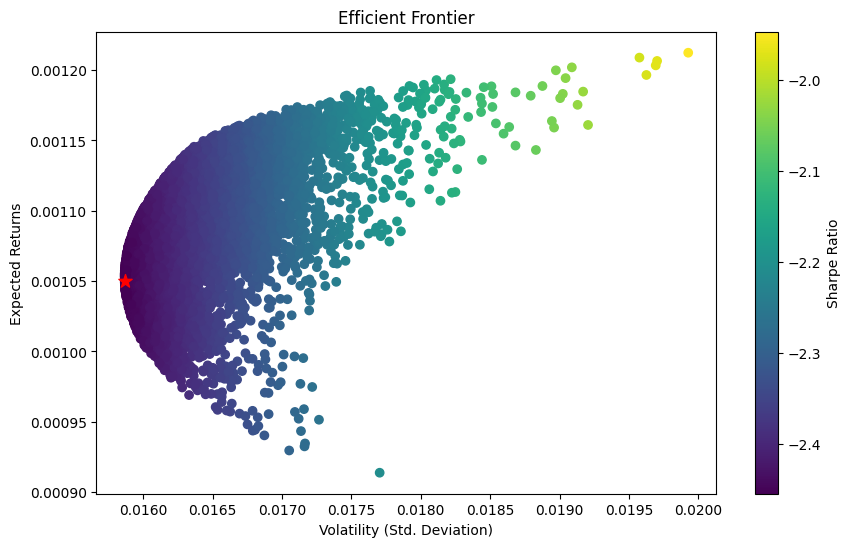

In [25]:
import matplotlib.pyplot as plt

def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, volatility

def generate_portfolios(mean_returns, cov_matrix, num_portfolios = 10000):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(tickers))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_return, portfolio_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_return
        results[1,i] = portfolio_volatility
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_volatility
    return results, weights_record

# Generate random portfolios
num_portfolios = 10000
results, weights = generate_portfolios(mean_returns, cov_matrix, num_portfolios)

# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')

# Highlight the optimal portfolio
opt_return, opt_volatility = portfolio_performance(optimal_weights, mean_returns, cov_matrix)
plt.scatter(opt_volatility, opt_return, c='red', marker='*', s=100)  # Optimal portfolio
plt.show()



<font size="5"><b>Backtesting</b></font> 
<p>Training my portfolio optimization model on historical data and then testing its performance on unseen future data to validate its effectiveness. </p>


Optimal Weights:
AAPL: 0.241319014744801
MSFT: 0.1272657493670253
GOOGL: 0.4292199093715685
AMZN: 0.20219532651660527


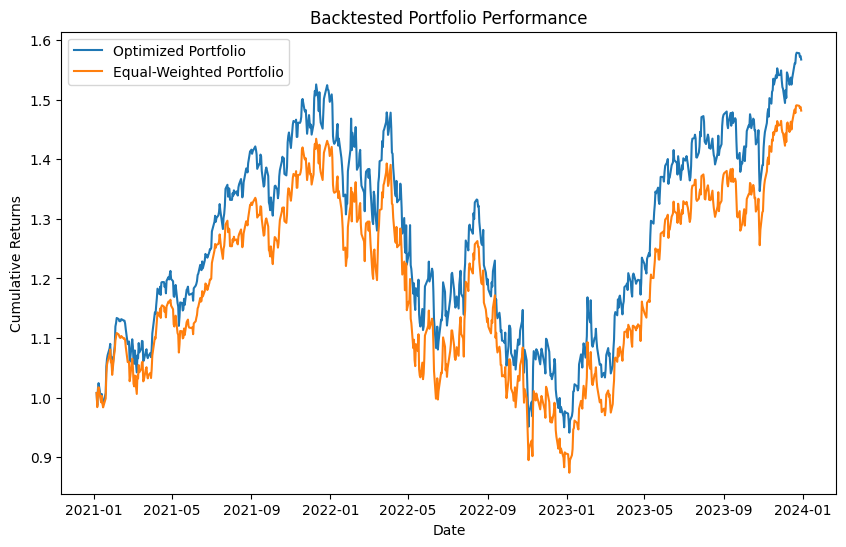

In [26]:
# Split data into training and testing sets
train_data = data[:'2021-01-01']
test_data = data['2021-01-01':]

# Recalculate returns and covariance matrix for the training set
train_returns = train_data.pct_change().dropna()
train_mean_returns = train_returns.mean()
train_cov_matrix = train_returns.cov()

# Re-optimize using training set
opt_results_train = minimize(
    neg_sharpe,
    init_guess,
    args=(train_mean_returns, train_cov_matrix, risk_free_rate),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

optimal_weights_train = opt_results_train.x

optimal_weights_dict_train = {tickers[i]: optimal_weights_train[i] for i in range(len(tickers))}
print("Optimal Weights:")
for ticker, weight in optimal_weights_dict_train.items():
    print(f"{ticker}: {weight}")

# Calculate test set performance
test_returns = test_data.pct_change().dropna()
test_portfolio_returns = (test_returns * optimal_weights_train).sum(axis=1)

# Align the test data index with the returns
aligned_test_index = test_returns.index

# Plot the test set performance
plt.figure(figsize=(10, 6))
plt.plot(aligned_test_index, (1 + test_portfolio_returns).cumprod(), label='Optimized Portfolio')
plt.plot(aligned_test_index, (1 + test_returns.mean(axis=1)).cumprod(), label='Equal-Weighted Portfolio')
plt.legend()
plt.title('Backtested Portfolio Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()
